Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Amazon Digital Music
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [3]:
# importa dataset 'amazon digital music'
data = pd.read_csv("../datasets/Amazon_Digital_Music/Digital_Music.csv", names=['user_id', 'item_id', 'rating', 'timestamp'])
dataset_name = 'Amazon_Digital_Music'
user_col = 'user_id'

data.shape

(1584082, 4)

In [4]:
data.head()

,user_id,item_id,rating,timestamp
0,0001388703,A1ZCPG3D3HGRSS,5.0,1387670400
1,0001388703,AC2PL52NKPL29,5.0,1378857600
2,0001388703,A1SUZXBDZSDQ3A,5.0,1362182400
3,0001388703,A3A0W7FZXM0IZW,5.0,1354406400
4,0001388703,A12R54MKO17TW0,5.0,1325894400


In [5]:
data['user_id'].value_counts() >= 5

B0135P6PZA     True
B00M8JCW3E     True
B00CZF8B68     True
B00NPZI1ZS     True
B00U3WJHCW     True
              ...  
B0029S2KKY    False
B0013R5L6M    False
B0070PVCX2    False
B01DNCH90K    False
B002A6Z4FS    False
Name: user_id, Length: 456992, dtype: bool

In [6]:
k_core_users = data['user_id'].value_counts()[ data['user_id'].value_counts() >= 5 ].index
k_core_users

Index(['B0135P6PZA', 'B00M8JCW3E', 'B00CZF8B68', 'B00NPZI1ZS', 'B00U3WJHCW',
       'B0092MKTL2', 'B005MVLI8A', 'B00136NUG6', 'B0170K9UTO', 'B0099G7KDQ',
       ...
       'B00JUF3MWO', 'B000E1E2IG', 'B000QQYEJG', 'B00LY3UOK8', 'B000W1RET2',
       'B0028H88VG', 'B00TPPZ60K', 'B000QL9D6A', 'B0096U6T28', 'B016Q4GGAQ'],
      dtype='object', length=50110)

In [7]:
data = data.set_index('user_id').loc[k_core_users].reset_index()
data.shape

(998936, 4)

### Keep only high ratings

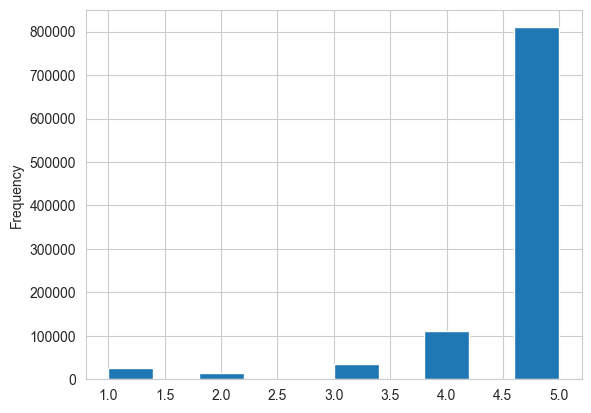

In [8]:
data['rating'].plot(kind='hist');

In [9]:
np.quantile(data['rating'], q=0.8)

5.0

In [10]:
pos_ratings = np.quantile(data['rating'], q=0.8)
pos_ratings

5.0

In [11]:
data = data[ data['rating'] == pos_ratings ].drop(columns='rating')
data.head()

,user_id,item_id,timestamp
0,B0135P6PZA,A1N25NY4EQL7I6,1443225600
1,B0135P6PZA,A14K5YWVJ1SV38,1443225600
2,B0135P6PZA,A11Y3UKBMR9VTT,1443225600
3,B0135P6PZA,AM327SL7RBMMW,1443139200
4,B0135P6PZA,ARTPRZWG3M212,1443139200


In [12]:
# number of remaining cases
data.shape[0]

809899

### Convert timestamp

In [13]:
%%time
data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x) ) # convert unix timestamp to date
data = data.sort_values(by='date') # sort by date

CPU times: total: 672 ms
Wall time: 852 ms


In [14]:
data.head()

,user_id,item_id,timestamp,date
39318,9714721180,A2SY49Z6H96QVR,877305600,1997-10-19 20:00:00
595856,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-27 19:00:00
595864,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-27 19:00:00
309450,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-21 20:00:00
309496,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-21 20:00:00


In [15]:
data.tail()

,user_id,item_id,timestamp,date
540983,B01H2N2XOI,AGITP40WOIGIM,1538179200,2018-09-28 20:00:00
877104,B01G7OH4KG,A1UACDAXDOWB2H,1538265600,2018-09-29 20:00:00
267893,B01GPDFR26,A312L5Z8SW61FR,1538265600,2018-09-29 20:00:00
262810,B01G4DH4AU,A7O6RHCU9RZ8L,1538352000,2018-09-30 20:00:00
231454,B01H7XADLS,A1X087SYY8ZFGC,1538438400,2018-10-01 20:00:00


In [16]:
%%time
# keep year-month
data['date'] = data['date'].apply(lambda x: datetime.strptime( str(x.year)+'-'+str(x.month), '%Y-%m' ))

CPU times: total: 8.42 s
Wall time: 11.3 s


In [17]:
data.head()

,user_id,item_id,timestamp,date
39318,9714721180,A2SY49Z6H96QVR,877305600,1997-10-01
595856,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-01
595864,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-01
309450,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-01
309496,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-01


---------------------------------------------------------------------------------------------
### Data.head() is showing different results from Klismam's...

In [18]:
data[data.timestamp==877305600]

,user_id,item_id,timestamp,date
39318,9714721180,A2SY49Z6H96QVR,877305600,1997-10-01


-- example ---------------------------

In [19]:
import pytz
from datetime import datetime

In [20]:
pytz.all_timezones_set.intersection(['GMT'])

{'GMT'}

In [21]:
ts = 877305600

In [22]:
datetime.fromtimestamp(ts)

datetime.datetime(1997, 10, 19, 20, 0)

In [23]:
utc_dt = datetime.utcfromtimestamp(ts)
utc_dt

datetime.datetime(1997, 10, 20, 0, 0)

In [24]:
aware_utc_dt = utc_dt.replace(tzinfo=pytz.utc)

tz = pytz.timezone('GMT')
dt = aware_utc_dt.astimezone(tz)
dt

datetime.datetime(1997, 10, 20, 0, 0, tzinfo=<StaticTzInfo 'GMT'>)

In [25]:
dt = datetime.fromtimestamp(ts, tz)
dt

datetime.datetime(1997, 10, 20, 0, 0, tzinfo=<StaticTzInfo 'GMT'>)

-- end example ---------------------------

In [26]:
data['date_utc'] = data['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x) ) # convert unix timestamp to date
data = data.sort_values(by='date_utc') # sort by date

In [27]:
data.head()

,user_id,item_id,timestamp,date,date_utc
39318,9714721180,A2SY49Z6H96QVR,877305600,1997-10-01,1997-10-20
595856,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-01,1997-11-28
595864,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-01,1997-11-28
309450,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-01,1998-04-22
309496,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-01,1998-04-22


In [28]:
data.tail()

,user_id,item_id,timestamp,date,date_utc
540983,B01H2N2XOI,AGITP40WOIGIM,1538179200,2018-09-01,2018-09-29
877104,B01G7OH4KG,A1UACDAXDOWB2H,1538265600,2018-09-01,2018-09-30
267893,B01GPDFR26,A312L5Z8SW61FR,1538265600,2018-09-01,2018-09-30
262810,B01G4DH4AU,A7O6RHCU9RZ8L,1538352000,2018-09-01,2018-10-01
231454,B01H7XADLS,A1X087SYY8ZFGC,1538438400,2018-10-01,2018-10-02


".fromtimestamp() might fail for past dates if a local timezone had different utc offset. You need a historic timezone database such as provided by pytz module (or your OS). Or just work in UTC and use .utcfromtimestamp()" - (https://stackoverflow.com/questions/3682748/converting-unix-timestamp-string-to-readable-date)

In [29]:
data = data.drop(columns=['date', 'date_utc'])
data['date'] = data['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x) ) # convert unix timestamp to date
data = data.sort_values(by='date') # sort by date
data.head()

,user_id,item_id,timestamp,date
39318,9714721180,A2SY49Z6H96QVR,877305600,1997-10-20
595856,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-28
595864,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-28
309450,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-22
309496,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-22


In [30]:
%%time
# keep year-month
data['date'] = data['date'].apply(lambda x: datetime.strptime( str(x.year)+'-'+str(x.month), '%Y-%m' ))

CPU times: total: 8.23 s
Wall time: 11.9 s


In [31]:
data.head()

,user_id,item_id,timestamp,date
39318,9714721180,A2SY49Z6H96QVR,877305600,1997-10-01
595856,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-01
595864,B0013D89TW,A2XT7XLQ8DD4NZ,880675200,1997-11-01
309450,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-01
309496,B00122Z4Y2,A3OS0Q4XX0QSA4,893203200,1998-04-01


### now it's SOLVED.
because of the drop of date, it seems that the utc problem was not an issue, but now it's certain.


---------------------------------------------------------------------------------------------

## Evaluating Time defined Buckets 

In [32]:
%%time
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: total: 109 ms
Wall time: 239 ms


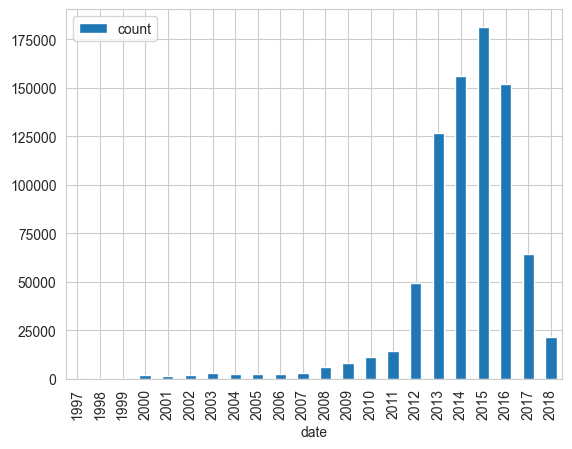

In [33]:
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.year
_.groupby('date').sum().plot(kind='bar');

In [34]:
y_filter = (data['date'] < datetime.strptime('2014-04', '%Y-%m')) & (datetime.strptime('2014', '%Y') <= data['date']) 
# y_filter = (data['date'] < datetime.strptime('2015', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 

In [35]:
data = data[y_filter]

In [36]:
# number of remaining cases
data.shape[0]

33630

Sampling the dataset - only most frequent users (overall)

In [37]:
data.groupby(by=['user_id'])['date'].nunique()

user_id
0001377647    2
0001388703    1
0001526146    1
0001527134    2
0006882919    1
             ..
B01E8ZF3D6    3
B01E9SVVHE    2
B01EE9N52C    1
B01FLMZ50G    1
B01HC8FQME    2
Name: date, Length: 13321, dtype: int64

In [38]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months = data.groupby(by=['user_id'])['date'].nunique()

CPU times: total: 15.6 ms
Wall time: 24.3 ms


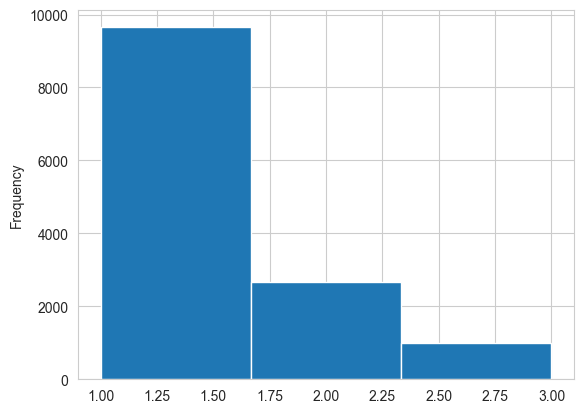

In [39]:
user_freq_over_months.plot(kind='hist',bins=user_freq_over_months.max());

In [40]:
_ = data.set_index('user_id').copy()

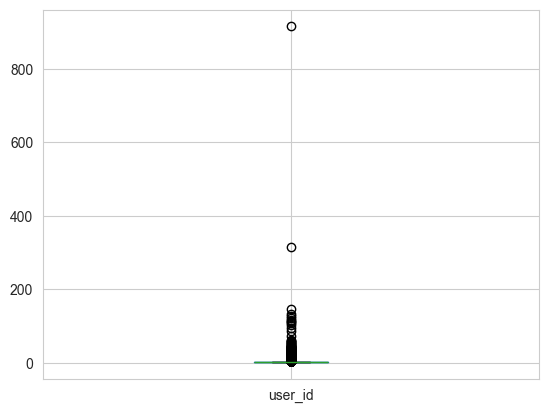

In [41]:
# frequency of users that occur every month:
_.reset_index()['user_id'].value_counts().plot(kind='box');

In [42]:
data['user_id'].value_counts()

B00CZF8B68    916
B00GLP4DMO    315
B00GG3OYMK    147
B0092MKTL2    133
B00IKS2BHY    127
             ... 
B003XBBLI8      1
B000TDYIZG      1
B005EVT8R6      1
B000W272EI      1
B00HETOR7C      1
Name: user_id, Length: 13321, dtype: int64

In [43]:
data['user_id'].value_counts().reset_index()['index'].to_list()[:5]

['B00CZF8B68', 'B00GLP4DMO', 'B00GG3OYMK', 'B0092MKTL2', 'B00IKS2BHY']

In [44]:
u = data['user_id'].value_counts().reset_index()['index'].to_list()

In [45]:
data['user_id'].shape[0]

33630

In [46]:
# to user, or not to use p ?
p = (data['user_id'].value_counts()/data['user_id'].shape[0])

In [47]:
prop = 0.75
s = round( len( u )*prop )

In [48]:
np.random.seed(42)
sampled_users = list( np.random.choice(u, size=s, replace=False, p=p) ) # , p=p

In [49]:
_.loc[sampled_users].shape

(29781, 3)

In [50]:
_.loc[sampled_users]['item_id'].nunique()

21663

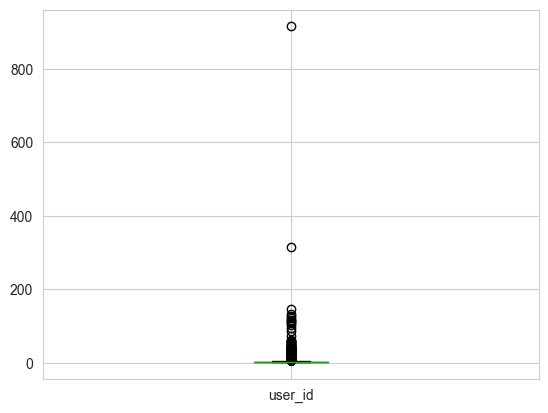

In [51]:
# frequency of users:
_.loc[sampled_users].reset_index()['user_id'].value_counts().plot(kind='box');

CPU times: total: 62.5 ms
Wall time: 127 ms


<Axes: ylabel='Frequency'>

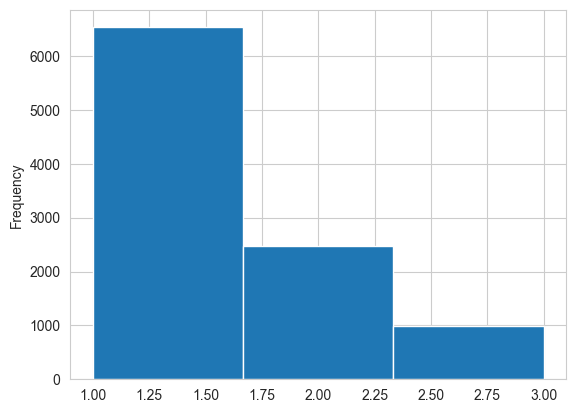

In [52]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months_sample = _.loc[sampled_users].reset_index().groupby(by=['user_id'])['date'].nunique()
user_freq_over_months_sample.plot(kind='hist',bins=user_freq_over_months_sample.max());

In [53]:
data['user_id'].nunique(), data['item_id'].nunique() # original number of users, original number of items

(13321, 24165)

In [54]:
# _.loc[freq_users].reset_index()['user_id'].nunique(), _.loc[freq_users].reset_index()['item_id'].nunique() # sample number of users, and of items
_.loc[sampled_users].reset_index()['user_id'].nunique(), _.loc[sampled_users].reset_index()['item_id'].nunique() # sample number of users, and of items

(9991, 21663)

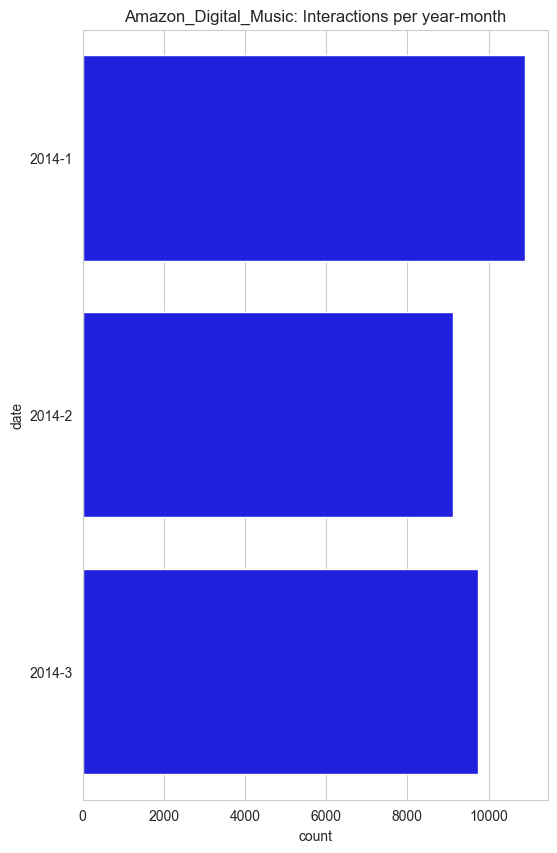

In [55]:
# %%time
# plot_interactions_per_month(data=_.loc[freq_users].reset_index(), dataset_name=dataset_name)
plot_interactions_per_month(data=_.loc[sampled_users].reset_index(), dataset_name=dataset_name)

In [56]:
USE_THRESHOLD = True
# all users 0.002736
# USING prop = 0.75 increased performance by a bit in the first month, 0.004292 (0.002878) ?
# USING prop = 0.5 reduced performance in the first month  	0.001647
# USING prop = 0.25 reduced performance in the first month 0.002574

if USE_THRESHOLD: 
    data = _.loc[sampled_users].reset_index()
    data = data.sort_values(by=['timestamp', 'user_id', 'item_id'])
    print(data.shape[0])
else:
    print(data.shape[0])
# new sample
data.to_csv('output/amazon_digmusic_dump/sampled_amazon_digmusic.csv', index=False)

29781


How many interactions occur in each month / year?

In [57]:
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: total: 109 ms
Wall time: 159 ms


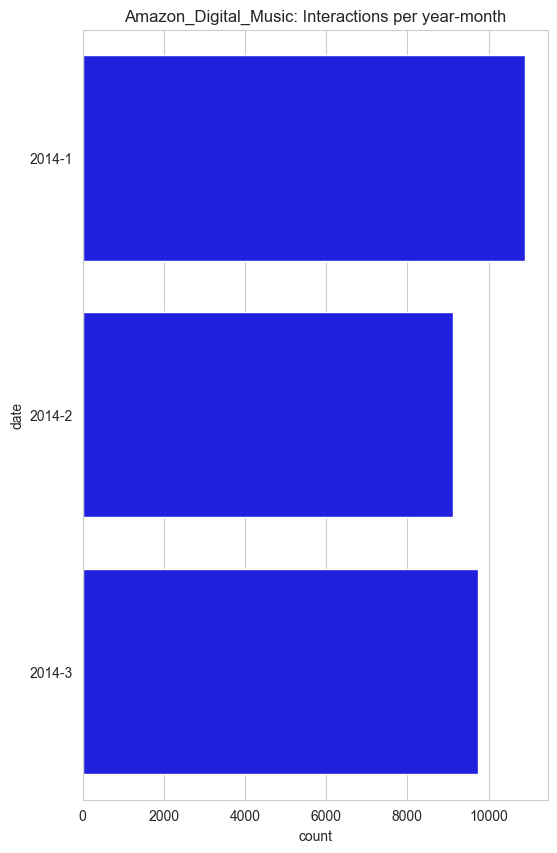

In [58]:
%%time
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [60]:
%%time
# 3min 16s
user_presence_df, user_month_interactions = get_interactions_info(data=data, user_col=user_col)

# new sample
user_presence_df.to_csv('output/amazon_digmusic_dump/sample_user_presence_df.csv', index=False)
user_month_interactions.to_csv('output/amazon_digmusic_dump/sample_user_month_interactions.csv', index=False)

0.0 %
CPU times: total: 31.7 s
Wall time: 39.9 s


In [67]:
user_presence_df.head()

,UserID,month_%
0,B00EHF64Y0,1.0
1,B0012288VS,1.0
2,B000TEL0BK,1.0
3,B00137QS28,1.0
4,B00H4IVMDA,1.0


In [68]:
user_presence_df[user_presence_df.UserID=='B00HRN0BZ2']

,UserID,month_%
690,B00HRN0BZ2,1.0


AttributeError: 'Axes' object has no attribute 'is_first_col'

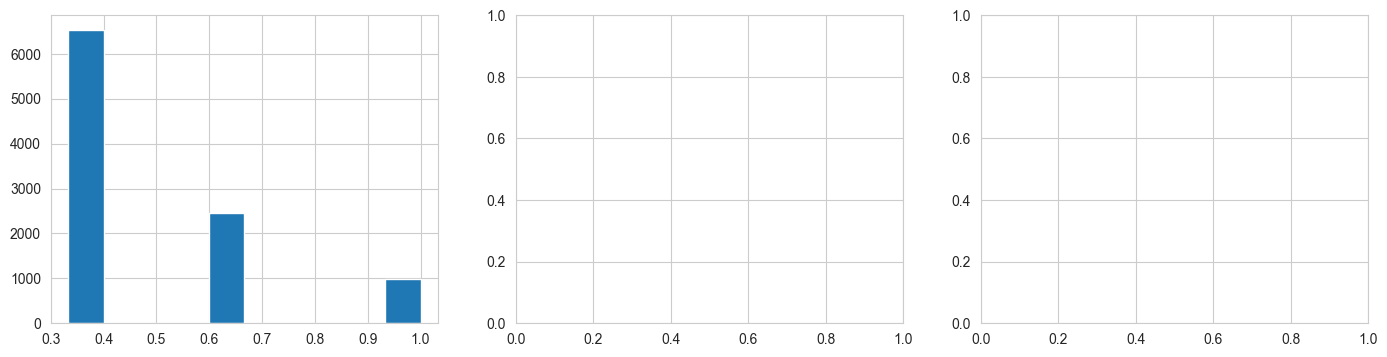

In [63]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

In [ ]:
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')

In [ ]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [69]:
# defining threshold
frequency_threshold = 1

In [70]:
# frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)
frequent_users_month = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

991 users of 9991 (9.919%) occurr in 100% or more months.


In [71]:
# old huge sample
# joblib.dump(frequent_users_month, 'output/amazonbooks_dump/frequent_users_month.joblib')

# new sample
joblib.dump(frequent_users_month, 'output/amazon_digmusic_dump/sample_frequent_users_month.joblib')

['output/amazon_digmusic_dump/sample_frequent_users_month.joblib']